## **Best model: SVC with sigmoid kernel, C = 0.2, HOG features**

In [1]:
%matplotlib inline
# from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

# import ast
import cv2
import skimage

from skimage.feature import hog, daisy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#models
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from torch import nn
import torchvision.models as models
from torchvision import transforms
# from torchsummary import summary
from torchvision import transforms
from PIL import Image

In [2]:
#old
with np.load('data (1).npz') as data:
    labels_old = data['arr_0']
    imgs_old = data['arr_1']
#     hog_feats = data['arr_2']

In [3]:
#new
#arr_0 is labels, arr_1 is images, arr_2 is hog features
with np.load('data (2).npz') as data:
    labels = data['arr_0']
    imgs = data['arr_1']
#     hog_feats = data['arr_2']

In [43]:
daisy_feats, daisy_ims = daisy(imgs[-1], visualize=True, step = 180, radius = 20)

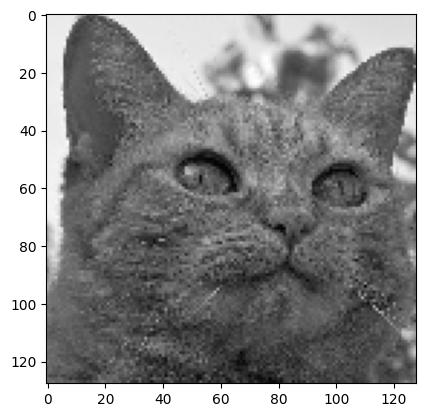

In [44]:
plt.imshow(imgs[-1], cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


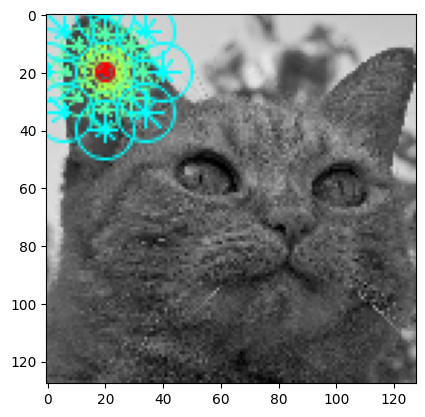

In [45]:
plt.imshow(daisy_ims, cmap ="gray")

### Canny Edge Detection

In [22]:
canny_feats = np.zeros(imgs.shape)
for im in range(0,imgs.shape[0]):
    edges = cv2.Canny(np.uint8(imgs[im]*255),100,200)
    canny_feats[im,:,:] = edges

In [23]:
canny_feats.shape

(2966, 128, 128)

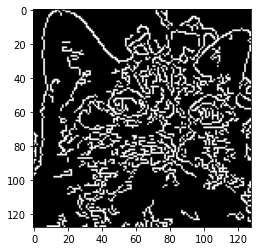

In [37]:
plt.imshow(canny_feats[-1], cmap="gray")
plt.savefig("./281 Final Report/cat_canny.png")

In [24]:
canny_ = canny_feats.reshape(canny_feats.shape[0], canny_feats.shape[1]*canny_feats.shape[2])
canny_.shape

(2966, 16384)

### Plotting functions

In [6]:
def get_features(in_imgs, feat_name='pixels'):
  featurelist = []
  sample_img = None

  if feat_name == 'pixels':
    # stack flattened images into array
    
    for i in range (in_imgs.shape[0]):
      featurelist.append(in_imgs[i, :, :].flatten()[np.newaxis, :])
    features = np.vstack(featurelist)
    sample_img = in_imgs[-1, :, :]
  
  if feat_name == 'hog':
    # stack extracted hog features into array
    # also save the first hog image for plotting
    for i in range(in_imgs.shape[0]):
        fd, hog_image = hog(in_imgs[i, :, :], orientations=6, pixels_per_cell=(16, 16), 
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        if i == (in_imgs.shape[0]-1):
          sample_img = hog_image
        featurelist.append(fd[np.newaxis, :])

  if feat_name == 'canny':
        for i in range(0,in_imgs.shape[0]):
            edges = cv2.Canny(np.uint8(in_imgs[i]*255),100,200,L2gradient = True)
            if i == (in_imgs.shape[0]-1):
                sample_img = edges
#             if i == 0:
#               sample_img = hog_image
            featurelist.append(edges.reshape(1, edges.shape[0]*edges.shape[1]))
#         featurelist = featurelist.reshape(featurelist.shape[0], featurelist.shape[1]*featurelist.shape[2])
  
  if sample_img is not None:
    # plot the sample image
    plt.figure(figsize=(5,5))
    plt.imshow(sample_img, cmap='gray')
    plt.axis('off')
    plt.show()

  if featurelist:
    return np.vstack(featurelist)

  return None


In [8]:
def plot_classes(X, y, ax, title):

  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project features into 2 dimensions
  for k in np.unique(y):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.7, facecolors = colorst[list(np.unique(y)).index(k)], s = 2)

  ax.set_title(title)

In [10]:
def get_PCA(X_list, n_components=2):
    pca_list = []
    xpca_list = []
    for X in X_list:
        pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
        X_pca = pca.transform(X)
        pca_list.append(pca)
        xpca_list.append(X_pca)
    return pca_list, xpca_list

def plot_PCA(X_list, n_components=2):
    pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'm-', 'k-']
    labels = ['pixel features', 'hog features', 'canny features']
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
#     plt.grid(b=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.show()

def get_tsne(X_list, n_components=2):
    xtsne_list = []
    for X in X_list:
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        xtsne_list.append(X_tsne)
    return xtsne_list

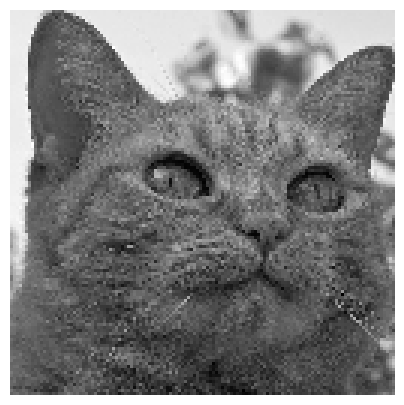

(1652, 16384)


/var/folders/_d/kjqjkq4d1hn0z5b5p1nkylgh0000gn/T/ipykernel_33379/3091968234.py:17: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(in_imgs[i, :, :], orientations=6, pixels_per_cell=(16, 16),


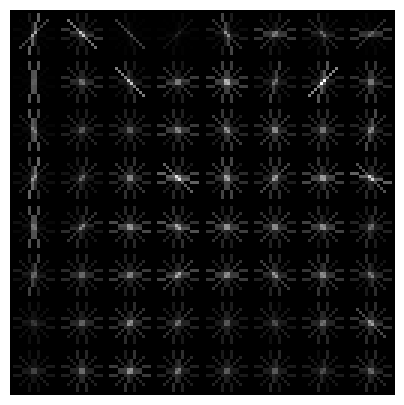

(1652, 1176)


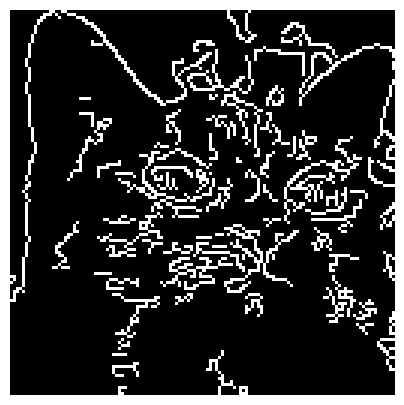

(1652, 16384)


In [15]:
pixel_features = get_features(imgs, feat_name='pixels')
print(pixel_features.shape)

hog_features = get_features(imgs, feat_name='hog')
print(hog_features.shape)

canny_features = get_features(imgs, feat_name='canny')
print(canny_features.shape)

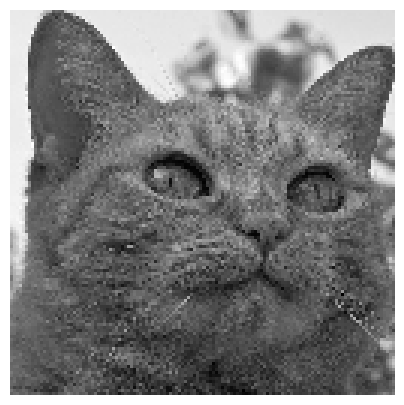

(2966, 16384)


/var/folders/_d/kjqjkq4d1hn0z5b5p1nkylgh0000gn/T/ipykernel_44988/2494631913.py:17: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(in_imgs[i, :, :], orientations=6, pixels_per_cell=(16, 16),


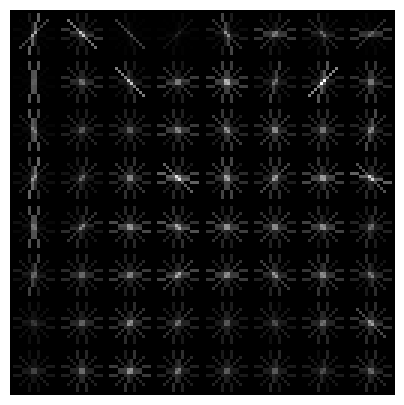

(2966, 1176)


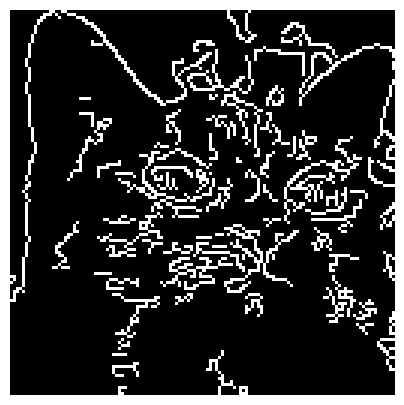

(2966, 16384)


In [11]:
pixel_features_old = get_features(imgs_old, feat_name='pixels')
print(pixel_features_old.shape)

hog_features_old = get_features(imgs_old, feat_name='hog')
print(hog_features_old.shape)

canny_features_old = get_features(imgs_old, feat_name='canny')
print(canny_features_old.shape)

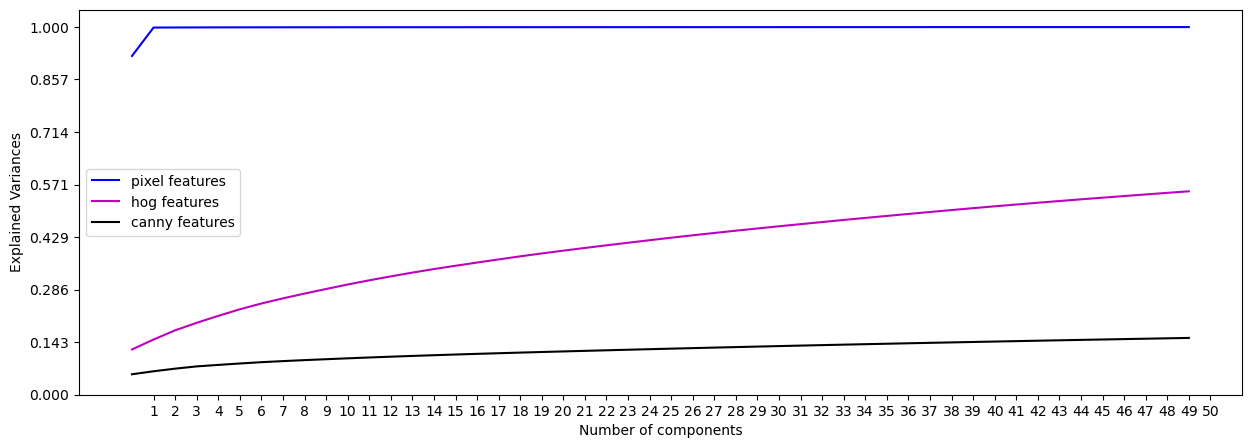

In [17]:
#old imgs
x = plot_PCA([pixel_features_old, hog_features_old, canny_features_old], n_components=50)

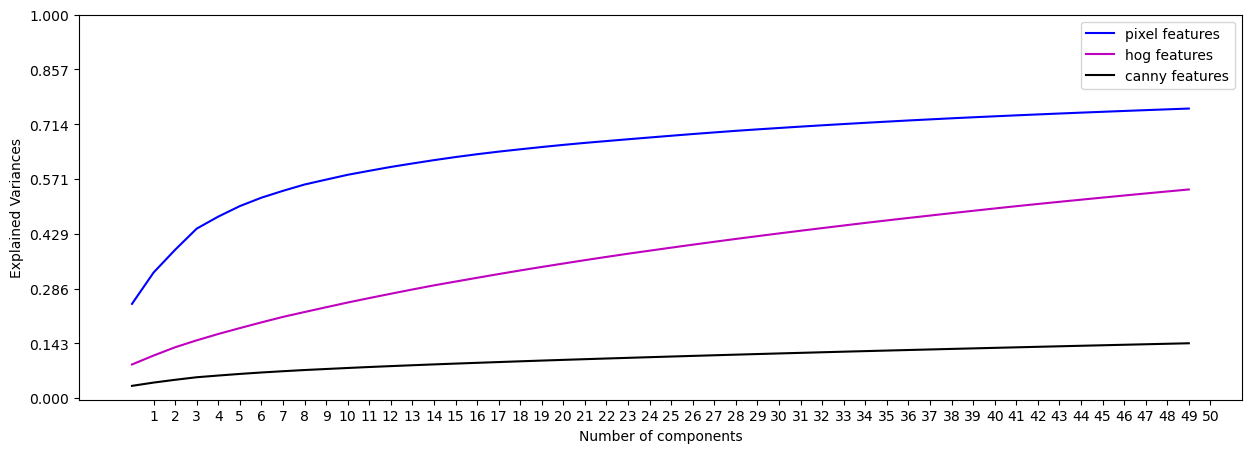

In [18]:
#new imgs
x = plot_PCA([pixel_features, hog_features, canny_features], n_components=50)

In [1]:
# X_pixels_pca, X_hog_pca, X_canny_pca = get_PCA([pixel_features, hog_features, canny_features], n_components=2)[-1]
# X_pixels_tsne, X_hog_tsne, X_canny_tsne = get_tsne([pixel_features, hog_features, canny_features], n_components=2)

In [12]:
X_pixels_pca_old, X_hog_pca_old, X_canny_pca_old = get_PCA([pixel_features_old, hog_features_old, canny_features_old], n_components=2)[-1]
X_pixels_tsne_old, X_hog_tsne_old, X_canny_tsne_old = get_tsne([pixel_features_old, hog_features_old, canny_features_old], n_components=2)

/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users

In [2]:
# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# # y is the class labels (person ID)
# plot_classes(X_pixels_pca, labels, ax[0,0], title='Pixel PCA')
# plot_classes(X_pixels_tsne, labels, ax[0,1], title='Pixel tSNE')

# plot_classes(X_hog_pca, labels, ax[1,0], title='Hog PCA')
# plot_classes(X_hog_tsne, labels, ax[1,1], title='Hog tSNE')

# plot_classes(X_canny_pca, labels, ax[2,0], title='Canny PCA')
# plot_classes(X_canny_tsne, labels, ax[2,1], title='Canny tSNE')

# plt.show()

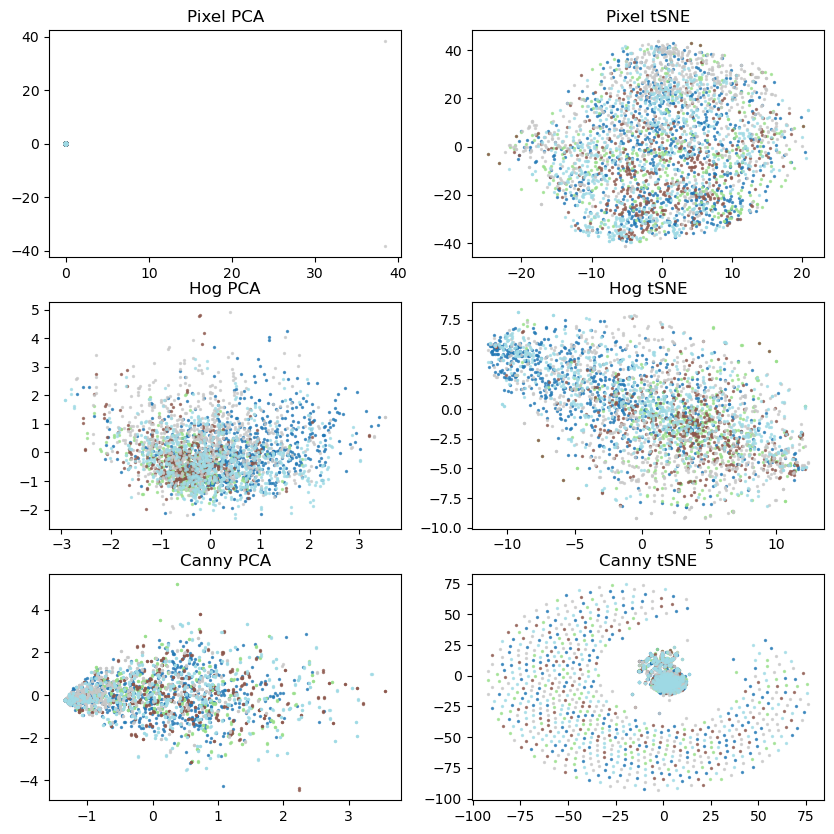

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

# y is the class labels (person ID)
plot_classes(X_pixels_pca_old, labels_old, ax[0,0], title='Pixel PCA')
plot_classes(X_pixels_tsne_old, labels_old, ax[0,1], title='Pixel tSNE')

plot_classes(X_hog_pca_old, labels_old, ax[1,0], title='Hog PCA')
plot_classes(X_hog_tsne_old, labels_old, ax[1,1], title='Hog tSNE')

plot_classes(X_canny_pca_old, labels_old, ax[2,0], title='Canny PCA')
plot_classes(X_canny_tsne_old, labels_old, ax[2,1], title='Canny tSNE')

plt.show()

# Modeling

In [20]:
def train_model(features, labels, model_type = 'mlp', c = 1, k = 'rbf', a = 'relu', alpha = 50):
    
    x_train,x_test,y_train,y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
#     x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
    
    if model_type == 'mlp' or model_type == 'all':
        clf = MLPClassifier(solver ='lbfgs',
                       activation = a,
                       alpha = alpha,
                       hidden_layer_sizes = (128,5),
                       random_state = 1,
                       max_iter = 500,
                       early_stopping = True,
                       verbose = False)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print('-'*30)
        print('MLP Results:')
        print(classification_report(y_test,y_pred))
        
        train_acc = clf.score(x_train, y_train)
        test_acc = clf.score(x_test, y_test)
        print(f"Train Accuracy: {train_acc}")
        print(f"Test Accuracy: {test_acc}")
    if model_type == 'all':
        print('-'*30)
        print('-'*30)
    if model_type == 'svc' or model_type == 'all':
        clf_svc = make_pipeline(StandardScaler(), SVC(
                  C = c,
                  kernel = k,
#                   class_weight = 'balanced',
                  random_state = 1,
                  max_iter =500,
                  verbose = False))
        clf_svc.fit(x_train,y_train)
        y_pred_svc = clf_svc.predict(x_test)
        print('SVC Results:')
        print(classification_report(y_test,y_pred_svc))

        train_acc = clf_svc.score(x_train, y_train)
        test_acc = clf_svc.score(x_test, y_test)
        print(f"Train Accuracy: {train_acc}")
        print(f"Test Accuracy: {test_acc}")

## Canny Models - Default Params

### PCA

In [25]:
#svc is better
train_model(X_canny_pca_old, labels = labels_old, model_type = 'all')

------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.33      0.01      0.01       156
          17       0.00      0.00      0.00        89
          18       0.00      0.00      0.00        87
          27       0.33      0.75      0.46       140
          64       0.24      0.52      0.32       122

    accuracy                           0.29       594
   macro avg       0.18      0.26      0.16       594
weighted avg       0.21      0.29      0.18       594

Train Accuracy: 0.33220910623946037
Test Accuracy: 0.28619528619528617
------------------------------
------------------------------


/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Cou

SVC Results:
              precision    recall  f1-score   support

           1       0.31      0.24      0.27       156
          17       0.42      0.06      0.10        89
          18       0.50      0.01      0.02        87
          27       0.34      0.74      0.46       140
          64       0.28      0.36      0.31       122

    accuracy                           0.32       594
   macro avg       0.37      0.28      0.23       594
weighted avg       0.36      0.32      0.26       594

Train Accuracy: 0.357504215851602
Test Accuracy: 0.31986531986531985


### Standard

In [35]:
train_model(canny_features_old, labels = labels_old, model_type = 'all')

/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.35      0.41      0.38       156
          17       0.24      0.19      0.21        89
          18       0.25      0.18      0.21        87
          27       0.37      0.31      0.33       140
          64       0.28      0.37      0.32       122

    accuracy                           0.31       594
   macro avg       0.30      0.29      0.29       594
weighted avg       0.31      0.31      0.31       594

Train Accuracy: 0.9679595278246206
Test Accuracy: 0.3114478114478115
------------------------------
------------------------------


/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.32      0.29      0.31       156
          17       0.00      0.00      0.00        89
          18       0.38      0.03      0.06        87
          27       0.36      0.75      0.48       140
          64       0.34      0.42      0.38       122

    accuracy                           0.35       594
   macro avg       0.28      0.30      0.25       594
weighted avg       0.29      0.35      0.28       594



/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Accuracy: 0.8267284991568297
Test Accuracy: 0.3451178451178451


# HOG Models - Default Params

### PCA

In [28]:
train_model(X_hog_pca_old, labels = labels_old, model_type = 'all')

------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.49      0.45      0.47       156
          17       0.34      0.36      0.35        89
          18       0.29      0.02      0.04        87
          27       0.40      0.54      0.46       140
          64       0.25      0.33      0.29       122

    accuracy                           0.37       594
   macro avg       0.35      0.34      0.32       594
weighted avg       0.37      0.37      0.35       594

Train Accuracy: 0.36467116357504215
Test Accuracy: 0.37037037037037035
------------------------------
------------------------------


/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.51      0.47      0.49       156
          17       0.33      0.22      0.27        89
          18       0.28      0.31      0.30        87
          27       0.40      0.48      0.44       140
          64       0.32      0.32      0.32       122

    accuracy                           0.38       594
   macro avg       0.37      0.36      0.36       594
weighted avg       0.38      0.38      0.38       594

Train Accuracy: 0.38195615514333897
Test Accuracy: 0.38215488215488214


### Standard

In [29]:
train_model(hog_features_old, labels = labels_old, model_type = 'all')

------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       156
          17       0.00      0.00      0.00        89
          18       0.00      0.00      0.00        87
          27       0.24      1.00      0.38       140
          64       0.00      0.00      0.00       122

    accuracy                           0.24       594
   macro avg       0.05      0.20      0.08       594
weighted avg       0.06      0.24      0.09       594

Train Accuracy: 0.25379426644182124
Test Accuracy: 0.2356902356902357
------------------------------
------------------------------


/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Cou

SVC Results:
              precision    recall  f1-score   support

           1       0.61      0.53      0.57       156
          17       0.36      0.27      0.31        89
          18       0.41      0.36      0.38        87
          27       0.56      0.69      0.62       140
          64       0.48      0.57      0.52       122

    accuracy                           0.51       594
   macro avg       0.49      0.48      0.48       594
weighted avg       0.51      0.51      0.50       594

Train Accuracy: 0.8827993254637436
Test Accuracy: 0.5117845117845118


# Combination Models - Default Params

In [34]:
feats = np.concatenate([hog_features_old,canny_features_old], axis = 1)
tsne_feats = np.concatenate([X_hog_tsne_old, X_canny_tsne_old], axis = 1)
pca_feats = np.concatenate([X_hog_pca_old, X_canny_pca_old], axis = 1)

### PCA

In [35]:
train_model(pca_feats, labels = labels_old, model_type = 'all', c= 0.25, k = 'sigmoid', a = 'tanh')

------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.49      0.38      0.43       156
          17       0.27      0.16      0.20        89
          18       0.15      0.03      0.06        87
          27       0.40      0.69      0.50       140
          64       0.26      0.34      0.29       122

    accuracy                           0.36       594
   macro avg       0.31      0.32      0.30       594
weighted avg       0.34      0.36      0.33       594

Train Accuracy: 0.37436762225969644
Test Accuracy: 0.35858585858585856
------------------------------
------------------------------


/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.31      0.30      0.31       156
          17       0.26      0.13      0.18        89
          18       0.27      0.11      0.16        87
          27       0.37      0.46      0.41       140
          64       0.18      0.27      0.21       122

    accuracy                           0.28       594
   macro avg       0.28      0.26      0.25       594
weighted avg       0.28      0.28      0.27       594

Train Accuracy: 0.28077571669477236
Test Accuracy: 0.27946127946127947


In [37]:
# train_model(feats, labels = labels_old, model_type = 'all',c= 0.25, k = 'sigmoid', a = 'tanh')

# SVC with Higher Regularization, Sigmoid Kernel

### HOG

In [33]:
train_model(hog_features_old, labels = labels_old, model_type = 'svc', c = 0.25, k = 'rbf')

/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.54      0.47      0.50       156
          17       0.25      0.01      0.02        89
          18       0.42      0.43      0.42        87
          27       0.49      0.78      0.60       140
          64       0.45      0.53      0.49       122

    accuracy                           0.48       594
   macro avg       0.43      0.44      0.41       594
weighted avg       0.45      0.48      0.44       594

Train Accuracy: 0.612141652613828
Test Accuracy: 0.4797979797979798


In [38]:
train_model(hog_features_old, labels = labels_old, model_type = 'svc', c = 0.2, k = 'sigmoid')

/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.54      0.49      0.52       156
          17       0.45      0.10      0.17        89
          18       0.42      0.43      0.42        87
          27       0.53      0.59      0.56       140
          64       0.44      0.66      0.53       122

    accuracy                           0.48       594
   macro avg       0.47      0.46      0.44       594
weighted avg       0.48      0.48      0.46       594

Train Accuracy: 0.556070826306914
Test Accuracy: 0.4831649831649832


### HOG PCA

In [33]:
train_model(X_hog_pca_old, labels = labels_old, model_type = 'svc', c = 0.5, k = 'sigmoid')

/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.30      0.39      0.34       156
          17       0.26      0.13      0.18        89
          18       0.00      0.00      0.00        87
          27       0.27      0.44      0.34       140
          64       0.17      0.16      0.17       122

    accuracy                           0.26       594
   macro avg       0.20      0.23      0.21       594
weighted avg       0.22      0.26      0.23       594

Train Accuracy: 0.27866779089376054
Test Accuracy: 0.25925925925925924


### Canny PCA

In [19]:
train_model(X_canny_pca_old, labels = labels_old, model_type = 'svc', c = 0.25, k = 'sigmoid')

/Users/Courtney/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC Results:
              precision    recall  f1-score   support

           1       0.22      0.16      0.19       156
          17       0.25      0.13      0.18        89
          18       0.12      0.11      0.12        87
          27       0.38      0.67      0.49       140
          64       0.19      0.16      0.18       122

    accuracy                           0.27       594
   macro avg       0.23      0.25      0.23       594
weighted avg       0.24      0.27      0.24       594

Train Accuracy: 0.26349072512647553
Test Accuracy: 0.27104377104377103


# MLP with higher L2 and tanh activation

In [29]:
train_model(hog_features_old, labels = labels_old, model_type = 'mlp', a = 'tanh', alpha = 75)

------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.51      0.40      0.45       156
          17       0.42      0.11      0.18        89
          18       0.44      0.37      0.40        87
          27       0.47      0.60      0.53       140
          64       0.41      0.66      0.51       122

    accuracy                           0.45       594
   macro avg       0.45      0.43      0.41       594
weighted avg       0.46      0.45      0.43       594

Train Accuracy: 0.5370994940978078
Test Accuracy: 0.45286195286195285


In [31]:
train_model(X_hog_pca_old, labels = labels_old, model_type = 'mlp', a = 'tanh', alpha = 50)

------------------------------
MLP Results:
              precision    recall  f1-score   support

           1       0.49      0.46      0.47       156
          17       0.32      0.26      0.28        89
          18       0.67      0.02      0.04        87
          27       0.40      0.53      0.45       140
          64       0.23      0.34      0.27       122

    accuracy                           0.36       594
   macro avg       0.42      0.32      0.31       594
weighted avg       0.41      0.36      0.34       594

Train Accuracy: 0.34527824620573355
Test Accuracy: 0.3569023569023569


In [4]:
# train_model(X_canny_pca_old, labels = labels_old, model_type = 'mlp', a = 'tanh', alpha = 50)

### Compare dataset class counts

In [240]:
np.asarray(np.unique(labels,return_counts = True)).transpose()

array([[  1, 700],
       [ 17, 352],
       [ 18, 316],
       [ 27,  94],
       [ 64, 190]])

In [241]:
np.asarray(np.unique(labels_old,return_counts = True)).transpose()

array([[  1, 700],
       [ 17, 404],
       [ 18, 436],
       [ 27, 742],
       [ 64, 684]])